<a href="https://colab.research.google.com/github/Demi-greaterme/My_sentiment_app/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Importing necessary libraries

!pip install newspaper3k
!pip install nltk
!pip install lxml_html_clean
!pip install spacy
!pip install transformers
!pip install scikit-learn
!pip install datasets
!pip install hf-xet
!pip install streamlit
!pip install scikit-learn
import nltk
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import datasets
import joblib
from newspaper import Article
from transformers import pipeline
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
from transformers import Trainer, TrainingArguments
nltk.download('punkt_tab')
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Scraping sentences

URL = "https://www.theguardian.com/news/2025/jun/03/mrbeast-jimmy-donaldson-youtube-videos-star"

article = Article(URL)
article.download()
article.parse()
article.nlp()

text = article.text
print(text)

Jimmy Donaldson, the 27-year-old online content creator and entrepreneur known as MrBeast, is by any reasonable metric one of the most popular entertainers on the planet. His YouTube channel, to which he posts his increasingly elaborate and expensively produced videos, has 400 million subscribers – more than the population of the United States of America and equivalent to the total number of native English speakers currently alive. It’s close to twice as many subscribers as Elon Musk has X followers, and over 100 million more than Taylor Swift has Instagram followers. And that number, 400 million, does not account for the people who watch MrBeast’s videos in passing, or who are aware of his cultural presence because of their children, or who just sort of know who he is but don’t have any intricate awareness as to why he is famous.

That number is the number of people who have made the volitional move of clicking that subscribe button, to ensure that they will a) not miss his latest vid

In [7]:
def process_raw_text_to_cleaned_sentences(raw_text_input):
    if not raw_text_input or not isinstance(raw_text_input, str):
        return []

    text_normalized_quotes = raw_text_input.replace("’", "'").replace("‘", "'").replace("`", "'")
    doc = nlp(text_normalized_quotes)

    cleaned_sentences = []
    for sent in doc.sents:
        sentence_text = sent.text
        cleaned = re.sub(r"[^a-zA-Z0-9\s\.,!'\"?\-()]", "", sentence_text)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        cleaned = cleaned.lower()
        if cleaned: # Add only if not empty after cleaning
            cleaned_sentences.append(cleaned)
    return cleaned_sentences

In [10]:
#Getting rid of special characters
cleaned_sentences = process_raw_text_to_cleaned_sentences(text)
print(len(cleaned_sentences))
print(cleaned_sentences[:25])

211
['jimmy donaldson, the 27-year-old online content creator and entrepreneur known as mrbeast, is by any reasonable metric one of the most popular entertainers on the planet.', 'his youtube channel, to which he posts his increasingly elaborate and expensively produced videos, has 400 million subscribers more than the population of the united states of america and equivalent to the total number of native english speakers currently alive.', "it's close to twice as many subscribers as elon musk has x followers, and over 100 million more than taylor swift has instagram followers.", "and that number, 400 million, does not account for the people who watch mrbeast's videos in passing, or who are aware of his cultural presence because of their children, or who just sort of know who he is but don't have any intricate awareness as to why he is famous.", 'that number is the number of people who have made the volitional move of clicking that subscribe button, to ensure that they will a) not miss

In [11]:
# creating a dataset for the snetences
df = pd.DataFrame({'sentence': cleaned_sentences})

df.to_csv('labeled_sentences.csv', index=False)

In [12]:
df = pd.read_csv("labeled_sentences.csv")

classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

df['label'] = df['sentence'].apply(lambda x: classifier(x)[0]['label'])

df.to_csv("labeled_sentences.csv", index=False)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [13]:
df.head()

,sentence,label
0,"jimmy donaldson, the 27-year-old online conten...",LABEL_2
1,"his youtube channel, to which he posts his inc...",LABEL_2
2,it's close to twice as many subscribers as elo...,LABEL_1
3,"and that number, 400 million, does not account...",LABEL_1
4,that number is the number of people who have m...,LABEL_2


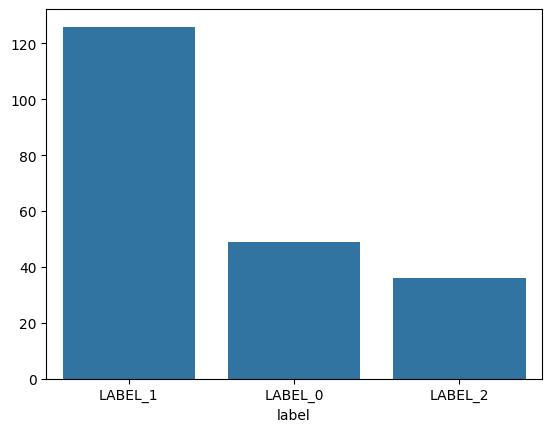

In [14]:
skewness = df['label'].value_counts()

sns.barplot(x=skewness.index, y=skewness.values)
plt.show()

In [15]:
# Handling categorical variables

label_map = {'label_0': 0, 'label_1': 1, 'label_2': 2}

df['label'] = df['label'].map(label_map)

dataset = Dataset.from_pandas(df)

In [16]:
# Tokenization + splitting
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)

dataset_split = tokenized_dataset.train_test_split(test_size=0.2)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


In [18]:
model_path = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

demo_text = "I had so much fun yesterday!"

prediction = sentiment_pipeline(demo_text)
print(prediction)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


[{'label': 'LABEL_1', 'score': 0.545263409614563}]


In [19]:
with open('model.joblib', 'wb') as f:
    joblib.dump(model, f)